##  Data understanding (1/12 of data)

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, confusion_matrix, classification_report, RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.utils import class_weight
from matplotlib import pyplot as plt
import seaborn as sns
import optuna
from optuna.pruners import HyperbandPruner
import warnings
import os
import gc
import dill
from IPython.display import Image, display
from datetime import datetime
import itertools
import lightgbm as lgb

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

For seeing the data structure I will start by exploring first file(1/12 of the data) 

In [2]:
df = pd.read_parquet('data/train_data_0.pq').astype('int32')
print(df.shape)
df.head()

(1974724, 61)


,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,...,3,3,3,4,1,3,4,1,0,0
1,0,2,18,9,14,14,12,12,0,3,...,0,0,0,4,1,3,4,1,0,0
2,0,3,18,9,4,8,1,11,11,0,...,0,0,0,4,1,2,3,1,1,1
3,0,4,4,1,9,12,16,7,12,2,...,3,3,3,4,1,3,1,1,0,0
4,0,5,5,12,15,2,11,12,10,2,...,3,3,3,4,1,3,4,1,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1974724 entries, 0 to 1974723
Data columns (total 61 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int32
 1   rn                             int32
 2   pre_since_opened               int32
 3   pre_since_confirmed            int32
 4   pre_pterm                      int32
 5   pre_fterm                      int32
 6   pre_till_pclose                int32
 7   pre_till_fclose                int32
 8   pre_loans_credit_limit         int32
 9   pre_loans_next_pay_summ        int32
 10  pre_loans_outstanding          int32
 11  pre_loans_total_overdue        int32
 12  pre_loans_max_overdue_sum      int32
 13  pre_loans_credit_cost_rate     int32
 14  pre_loans5                     int32
 15  pre_loans530                   int32
 16  pre_loans3060                  int32
 17  pre_loans6090                  int32
 18  pre_loans90                    int32
 19  

In [4]:
# checking for duplicated values
df.duplicated().sum()

0

In [5]:
# checking for missing values
df.isna().sum().sum()

0

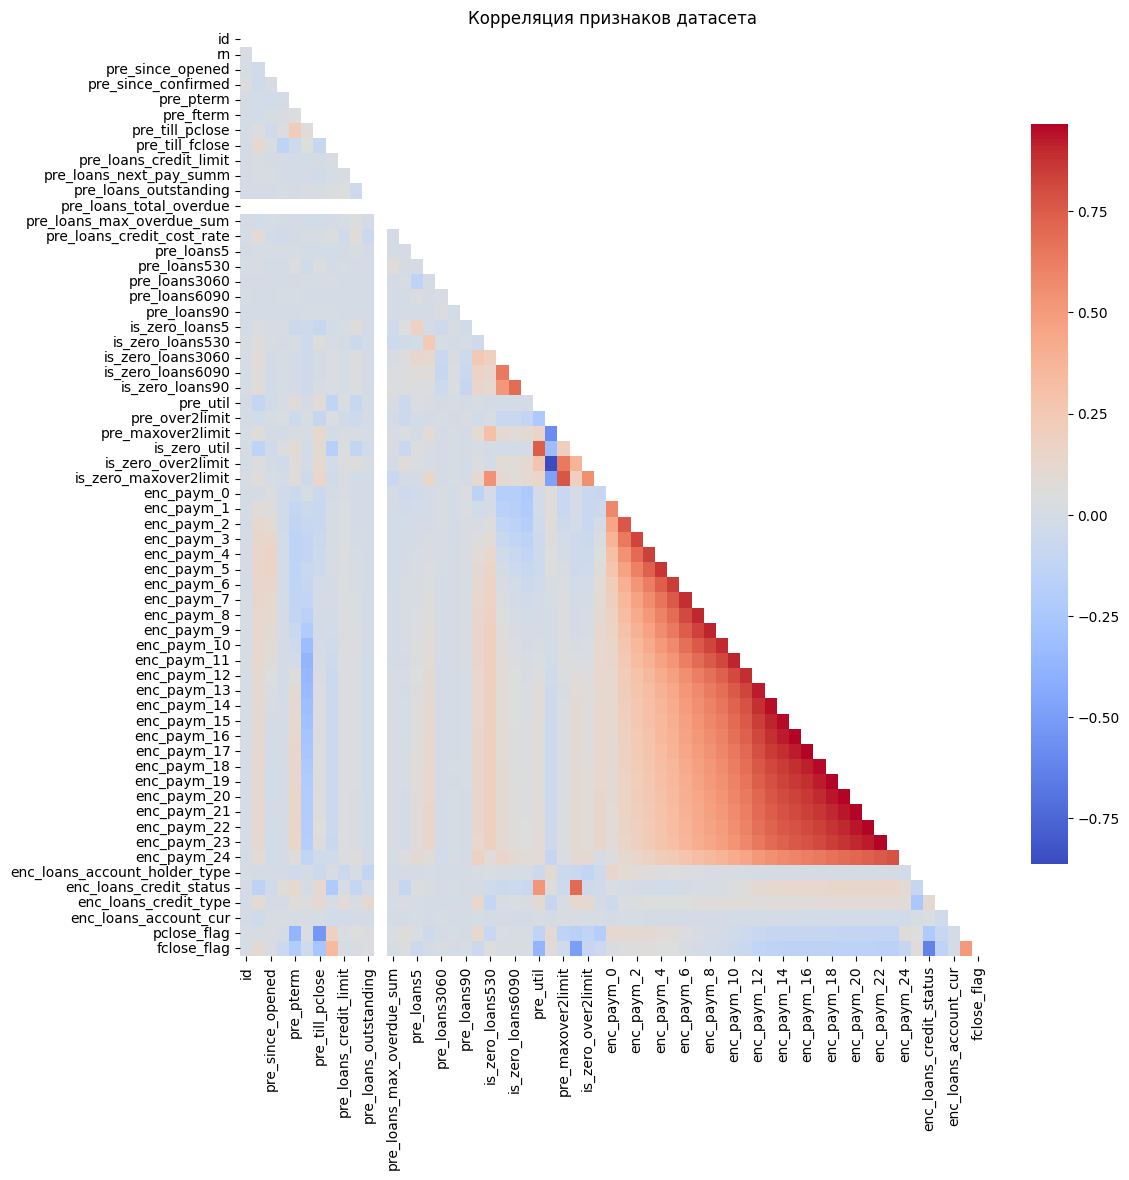

In [6]:
# Correlation matrix
plt.figure(figsize=(12, 12))

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(df.corr(), dtype=bool))

# Use seaborn to create the heatmap without annotation
sns.heatmap(df.corr(), mask=mask, annot=False, cmap='coolwarm', cbar_kws={"shrink": .8})

plt.title("Корреляция признаков датасета")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


One attribute consists of a single value. The “monthly payment statuses” features are highly correlated across adjacent months. Several traits are highly inversely correlated.

In [7]:
df.columns

Index(['id', 'rn', 'pre_since_opened', 'pre_since_confirmed', 'pre_pterm',
       'pre_fterm', 'pre_till_pclose', 'pre_till_fclose',
       'pre_loans_credit_limit', 'pre_loans_next_pay_summ',
       'pre_loans_outstanding', 'pre_loans_total_overdue',
       'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_loans5',
       'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90',
       'is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060',
       'is_zero_loans6090', 'is_zero_loans90', 'pre_util', 'pre_over2limit',
       'pre_maxover2limit', 'is_zero_util', 'is_zero_over2limit',
       'is_zero_maxover2limit', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2',
       'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7',
       'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12',
       'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16',
       'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20',
       'enc_paym_21', 

In [8]:
# Список бинаризированных колонок.
binary_cols = ['pre_since_opened', 'pre_since_confirmed', 'pre_pterm', 'pre_fterm', 'pre_till_pclose', 'pre_till_fclose', 
               'pre_loans_credit_limit', 'pre_loans_next_pay_summ', 'pre_loans_outstanding', 'pre_loans_total_overdue', 
               'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_loans5', 'pre_loans530', 'pre_loans3060',
               'pre_loans6090', 'pre_loans90', 'pre_util', 'pre_over2limit','pre_maxover2limit']

print(len(binary_cols))

20


In [9]:
#  значениями бинаризированных колонок.
for column in binary_cols:    
    column_name = df[column]
    print(f"Характеристика: {column} \nКоличество уникальных значений: {column_name.nunique()} \nСписок значений: \n{column_name.value_counts(dropna=False)} \n")

Характеристика: pre_since_opened 
Количество уникальных значений: 20 
Список значений: 
pre_since_opened
18    159072
6     154230
13    141904
4     138266
8     133032
0     111331
7      96090
19     94237
2      91807
10     91017
9      90118
17     86449
1      85775
11     82871
3      82231
5      80730
14     78560
15     73219
12     71609
16     32176
Name: count, dtype: int64 

Характеристика: pre_since_confirmed 
Количество уникальных значений: 18 
Список значений: 
pre_since_confirmed
9     418663
6     169181
14    134266
3     123579
17    116876
4     106465
8     101021
7      99650
13     84393
10     83769
0      80598
12     79820
2      77607
1      76836
16     75548
5      74440
11     71962
15        50
Name: count, dtype: int64 

Характеристика: pre_pterm 
Количество уникальных значений: 18 
Список значений: 
pre_pterm
4     374796
14    152466
7     126906
2     121765
16    110465
17    109905
8     109871
9     109775
1     108185
13    105364
15    102845


In [10]:
coded_cols = ['enc_paym_0', 'enc_paym_1', 'enc_paym_2', 'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7',
              'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12', 'enc_paym_13', 'enc_paym_14',
              'enc_paym_15', 'enc_paym_16', 'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20', 'enc_paym_21',
              'enc_paym_22', 'enc_paym_23', 'enc_paym_24', 'enc_loans_account_holder_type', 'enc_loans_credit_status',
              'enc_loans_credit_type', 'enc_loans_account_cur']

print(len(coded_cols))

29


In [11]:
# Familiarization with the meanings of encoded features.
for column in coded_cols:    
    column_name = df[column]
    print(f"Характеристика: {column} \nКоличество уникальных значений: {column_name.nunique()} \nСписок значений: \n{column_name.value_counts(dropna=False)} \n")

Характеристика: enc_paym_0 
Количество уникальных значений: 4 
Список значений: 
enc_paym_0
0    1791770
3      88319
1      87480
2       7155
Name: count, dtype: int64 

Характеристика: enc_paym_1 
Количество уникальных значений: 4 
Список значений: 
enc_paym_1
0    1635644
3     205080
1     124300
2       9700
Name: count, dtype: int64 

Характеристика: enc_paym_2 
Количество уникальных значений: 4 
Список значений: 
enc_paym_2
0    1556292
3     299304
1     110228
2       8900
Name: count, dtype: int64 

Характеристика: enc_paym_3 
Количество уникальных значений: 4 
Список значений: 
enc_paym_3
0    1474594
3     386940
1     104846
2       8344
Name: count, dtype: int64 

Характеристика: enc_paym_4 
Количество уникальных значений: 4 
Список значений: 
enc_paym_4
0    1383266
3     486048
1      97863
2       7547
Name: count, dtype: int64 

Характеристика: enc_paym_5 
Количество уникальных значений: 4 
Список значений: 
enc_paym_5
0    1300408
3     576932
1      90451
2       6

In [12]:
flag_cols = ['is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90', 'is_zero_util',
             'is_zero_over2limit', 'is_zero_maxover2limit', 'pclose_flag', 'fclose_flag' ]

print(len(flag_cols))

10


In [13]:
#  значения признаков-флагов.
for column in df.columns:
    column_name = df[column]
    print(f"Характеристика: {column} \n"
          f"Количество уникальных значений: {column_name.nunique()} \n"
          f"Список значений: \n{column_name.value_counts(dropna=False)} \n")

Характеристика: rn 
Количество уникальных значений: 46 
Список значений: 
rn
3     21776
2     21377
4     21152
1     20672
5     19778
6     18970
7     17377
8     15366
9     13741
10    12101
11    10541
12     8959
13     7718
14     6419
15     5759
16     5083
17     4356
18     3824
19     3097
20     2625
21     2106
22     1708
23     1368
24     1025
25      812
26      594
27      442
28      344
29      242
30      179
31      131
32      110
33       86
34       65
35       27
37       22
36       21
38        7
40        6
43        4
39        4
41        2
51        1
44        1
46        1
42        1
Name: count, dtype: int64 

Характеристика: is_zero_loans5 
Количество уникальных значений: 239 
Список значений: 
is_zero_loans5
1.000000    152974
0.750000      7322
0.800000      6750
0.666667      6631
0.833333      6369
             ...  
0.815789         1
0.566667         1
0.480000         1
0.423077         1
0.111111         1
Name: count, Length: 239, dtype:

Характеристика: pre_since_confirmed_9 
Количество уникальных значений: 24 
Список значений: 
pre_since_confirmed_9
0     93871
1     57582
2     35241
3     23510
4     15165
5      9900
6      6025
7      3587
8      2130
9      1160
10      723
11      454
12      252
13      138
14       86
15       69
16       37
17       26
18       14
19       13
20       11
23        3
21        2
25        1
Name: count, dtype: int64 

Характеристика: pre_since_confirmed_10 
Количество уникальных значений: 16 
Список значений: 
pre_since_confirmed_10
0     185048
1      50399
2      11470
3       2376
4        497
5        116
6         36
7         25
8         13
9          5
15         4
12         4
10         3
11         2
16         1
18         1
Name: count, dtype: int64 

Характеристика: pre_since_confirmed_11 
Количество уникальных значений: 15 
Список значений: 
pre_since_confirmed_11
0     197108
1      39696
2       9512
3       2460
4        732
5        260
6        122
7       

Характеристика: pre_fterm_2 
Количество уникальных значений: 10 
Список значений: 
pre_fterm_2
0    178816
1     49435
2     15597
3      4408
4      1277
5       339
6        97
7        26
8         3
9         2
Name: count, dtype: int64 

Характеристика: pre_fterm_3 
Количество уникальных значений: 29 
Список значений: 
pre_fterm_3
0     217195
1      23084
2       4680
3       1491
4        794
5        523
6        415
7        345
8        296
9        250
10       240
11       166
12       152
13       116
14        86
15        37
16        36
17        26
18        17
21        13
20        12
19        12
23         3
22         3
26         2
25         2
24         2
28         1
30         1
Name: count, dtype: int64 

Характеристика: pre_fterm_5 
Количество уникальных значений: 16 
Список значений: 
pre_fterm_5
0     186927
1      42896
2      13230
3       4342
4       1485
5        589
6        260
7        134
8         58
9         31
10        20
11         9
12    

Характеристика: pre_till_pclose_14 
Количество уникальных значений: 11 
Список значений: 
pre_till_pclose_14
0     182165
1      52596
2      11933
3       2634
4        532
5        105
6         23
7          8
8          2
10         1
9          1
Name: count, dtype: int64 

Характеристика: pre_till_pclose_15 
Количество уникальных значений: 18 
Список значений: 
pre_till_pclose_15
0     182504
1      48256
2      13495
3       3618
4       1172
5        431
6        223
7        117
8         76
9         35
10        26
12        19
11        15
15         4
13         4
14         2
16         2
21         1
Name: count, dtype: int64 

Характеристика: pre_till_pclose_16 
Количество уникальных значений: 17 
Список значений: 
pre_till_pclose_16
0     177914
1      51336
2      14802
3       4058
4       1190
5        383
6        159
7         67
8         41
9         24
10        10
11         7
13         3
16         2
14         2
15         1
19         1
Name: count, dtype:

Характеристика: pre_loans_credit_limit_8 
Количество уникальных значений: 11 
Список значений: 
pre_loans_credit_limit_8
0     172493
1      57539
2      15244
3       3653
4        827
5        174
6         52
7         10
8          5
11         2
9          1
Name: count, dtype: int64 

Характеристика: pre_loans_credit_limit_9 
Количество уникальных значений: 7 
Список значений: 
pre_loans_credit_limit_9
0    214312
1     30723
2      4326
3       550
4        73
5        15
7         1
Name: count, dtype: int64 

Характеристика: pre_loans_credit_limit_10 
Количество уникальных значений: 12 
Список значений: 
pre_loans_credit_limit_10
0     169412
1      57291
2      16896
3       4709
4       1245
5        330
6         93
7         14
9          4
8          4
11         1
10         1
Name: count, dtype: int64 

Характеристика: pre_loans_credit_limit_11 
Количество уникальных значений: 9 
Список значений: 
pre_loans_credit_limit_11
0    172229
1     56065
2     16224
3      4185

Характеристика: pre_loans5_infrequent_sklearn 
Количество уникальных значений: 3 
Список значений: 
pre_loans5_infrequent_sklearn
0    249853
1       140
2         7
Name: count, dtype: int64 

Характеристика: pre_loans530_0 
Количество уникальных значений: 5 
Список значений: 
pre_loans530_0
0    242115
1      7129
2       693
3        60
4         3
Name: count, dtype: int64 

Характеристика: pre_loans530_2 
Количество уникальных значений: 3 
Список значений: 
pre_loans530_2
0    249699
1       296
2         5
Name: count, dtype: int64 

Характеристика: pre_loans530_3 
Количество уникальных значений: 3 
Список значений: 
pre_loans530_3
0    249330
1       646
2        24
Name: count, dtype: int64 

Характеристика: pre_loans530_6 
Количество уникальных значений: 4 
Список значений: 
pre_loans530_6
0    248571
1      1381
2        47
3         1
Name: count, dtype: int64 

Характеристика: pre_loans530_13 
Количество уникальных значений: 8 
Список значений: 
pre_loans530_13
0    225075


Характеристика: pre_maxover2limit_11 
Количество уникальных значений: 7 
Список значений: 
pre_maxover2limit_11
0    242185
1      7273
2       494
3        42
4         4
5         1
6         1
Name: count, dtype: int64 

Характеристика: pre_maxover2limit_12 
Количество уникальных значений: 3 
Список значений: 
pre_maxover2limit_12
0    249454
1       541
2         5
Name: count, dtype: int64 

Характеристика: pre_maxover2limit_13 
Количество уникальных значений: 3 
Список значений: 
pre_maxover2limit_13
0    249706
1       288
2         6
Name: count, dtype: int64 

Характеристика: pre_maxover2limit_14 
Количество уникальных значений: 3 
Список значений: 
pre_maxover2limit_14
0    249421
1       573
2         6
Name: count, dtype: int64 

Характеристика: pre_maxover2limit_15 
Количество уникальных значений: 5 
Список значений: 
pre_maxover2limit_15
0    247389
1      2532
2        76
3         2
4         1
Name: count, dtype: int64 

Характеристика: pre_maxover2limit_16 
Количество

Характеристика: enc_paym_4_0 
Количество уникальных значений: 31 
Список значений: 
enc_paym_4_0
1     29430
2     28694
3     27262
4     25218
5     22512
6     19477
7     16920
8     13788
0     12599
9     11491
10     9428
11     7573
12     6175
13     4923
14     3819
15     3093
16     2340
17     1681
18     1186
19      838
20      608
21      369
22      241
23      119
24       92
25       59
26       30
27       22
28        8
29        4
30        1
Name: count, dtype: int64 

Характеристика: enc_paym_4_1 
Количество уникальных значений: 14 
Список значений: 
enc_paym_4_1
0     188846
1      39162
2      13343
3       5124
4       2065
5        841
6        342
7        168
8         64
9         28
11         8
10         7
16         1
12         1
Name: count, dtype: int64 

Характеристика: enc_paym_4_2 
Количество уникальных значений: 5 
Список значений: 
enc_paym_4_2
0    243116
1      6286
2       540
3        51
4         7
Name: count, dtype: int64 

Характеристи

Характеристика: enc_paym_10_0 
Количество уникальных значений: 24 
Список значений: 
enc_paym_10_0
1     41412
2     38509
0     34582
3     33239
4     27312
5     21460
6     16231
7     11903
8      8431
9      5969
10     4006
11     2659
12     1737
13     1048
14      645
15      350
16      213
17      146
18       77
19       36
20       15
21       11
22        7
23        2
Name: count, dtype: int64 

Характеристика: enc_paym_10_1 
Количество уникальных значений: 11 
Список значений: 
enc_paym_10_1
0     208787
1      29990
2       7851
3       2295
4        769
5        214
6         65
7         17
8          8
9          3
11         1
Name: count, dtype: int64 

Характеристика: enc_paym_10_2 
Количество уникальных значений: 5 
Список значений: 
enc_paym_10_2
0    246495
1      3295
2       197
3        12
4         1
Name: count, dtype: int64 

Характеристика: enc_paym_10_3 
Количество уникальных значений: 42 
Список значений: 
enc_paym_10_3
1     42194
2     39668
3     

Характеристика: enc_paym_16_0 
Количество уникальных значений: 20 
Список значений: 
enc_paym_16_0
0     61989
1     55197
2     44793
3     32444
4     21917
5     13897
6      8421
7      5004
8      2987
9      1525
10      868
11      440
12      247
13      131
14       71
15       40
16       15
17        9
18        4
20        1
Name: count, dtype: int64 

Характеристика: enc_paym_16_1 
Количество уникальных значений: 9 
Список значений: 
enc_paym_16_1
0    220590
1     23064
2      4831
3      1129
4       285
5        78
6        16
7         6
8         1
Name: count, dtype: int64 

Характеристика: enc_paym_16_2 
Количество уникальных значений: 5 
Список значений: 
enc_paym_16_2
0    247359
1      2475
2       153
3        12
5         1
Name: count, dtype: int64 

Характеристика: enc_paym_16_3 
Количество уникальных значений: 45 
Список значений: 
enc_paym_16_3
2     31784
1     31184
3     29366
4     25934
5     22903
6     19147
7     15711
8     12801
9     10416
0     

Характеристика: enc_paym_22_0 
Количество уникальных значений: 19 
Список значений: 
enc_paym_22_0
0     79546
1     62406
2     45100
3     28224
4     16281
5      8912
6      4897
7      2355
8      1109
9       612
10      305
11      121
12       65
13       32
14       20
15       10
16        3
17        1
18        1
Name: count, dtype: int64 

Характеристика: enc_paym_22_1 
Количество уникальных значений: 8 
Список значений: 
enc_paym_22_1
0    227352
1     18653
2      3187
3       635
4       137
5        28
6         7
7         1
Name: count, dtype: int64 

Характеристика: enc_paym_22_2 
Количество уникальных значений: 4 
Список значений: 
enc_paym_22_2
0    247976
1      1920
2       100
3         4
Name: count, dtype: int64 

Характеристика: enc_paym_22_3 
Количество уникальных значений: 45 
Список значений: 
enc_paym_22_3
2     28834
1     28050
3     27611
4     25057
5     22450
6     19507
7     16565
8     13806
9     11417
10     9486
11     7815
12     6474
0     

Характеристика: enc_loans_credit_type_1 
Количество уникальных значений: 16 
Список значений: 
enc_loans_credit_type_1
0     155025
1      54661
2      22405
3       9605
4       4367
5       2025
6        993
7        478
8        228
9        110
10        58
11        22
12        15
13         6
28         1
14         1
Name: count, dtype: int64 

Характеристика: enc_loans_credit_type_2 
Количество уникальных значений: 13 
Список значений: 
enc_loans_credit_type_2
0     213605
1      26502
2       7103
3       1975
4        549
5        167
6         59
7         22
8         12
10         2
9          2
11         1
12         1
Name: count, dtype: int64 

Характеристика: enc_loans_credit_type_3 
Количество уникальных значений: 22 
Список значений: 
enc_loans_credit_type_3
1     67361
2     56381
3     38521
0     36967
4     23114
5     13095
6      7078
7      3658
8      1820
9       980
10      479
11      234
12      153
13       67
14       38
15       25
16       11
17    

In [14]:
 # задействуем опцию "показывать все колонки"
pd.set_option('display.max_columns', None) 

In [15]:
df[binary_cols]

,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_total_overdue,pre_loans_max_overdue_sum,pre_loans_credit_cost_rate,pre_loans5,pre_loans530,pre_loans3060,pre_loans6090,pre_loans90,pre_util,pre_over2limit,pre_maxover2limit
0,18,9,2,3,16,10,11,3,3,0,2,11,6,16,5,4,8,16,2,17
1,18,9,14,14,12,12,0,3,3,0,2,11,6,16,5,4,8,16,2,17
2,18,9,4,8,1,11,11,0,5,0,2,8,6,16,5,4,8,15,2,17
3,4,1,9,12,16,7,12,2,3,0,2,4,6,16,5,4,8,16,2,17
4,5,12,15,2,11,12,10,2,3,0,2,4,6,16,5,4,8,16,2,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974719,1,9,14,8,10,11,8,4,2,0,2,4,6,16,5,4,8,11,2,17
1974720,7,9,4,8,1,11,19,1,4,0,2,7,6,16,5,4,8,7,2,17
1974721,9,0,10,8,10,11,16,2,3,0,2,7,6,16,5,4,8,16,2,17
1974722,9,16,10,13,10,4,12,2,3,0,2,7,6,16,5,4,8,16,2,17


In [16]:
df[coded_cols]     

,enc_paym_0,enc_paym_1,enc_paym_2,enc_paym_3,enc_paym_4,enc_paym_5,enc_paym_6,enc_paym_7,enc_paym_8,enc_paym_9,...,enc_paym_19,enc_paym_20,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur
0,0,0,3,3,3,3,3,3,3,3,...,3,4,3,3,3,4,1,3,4,1
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,4,1,3,4,1
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,4,1,2,3,1
3,1,0,0,0,0,0,0,0,0,0,...,3,4,3,3,3,4,1,3,1,1
4,0,0,0,0,0,0,0,3,3,3,...,3,4,3,3,3,4,1,3,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974719,0,0,0,0,0,0,0,0,0,0,...,3,4,3,3,3,4,1,2,3,1
1974720,0,0,0,0,0,3,3,3,3,3,...,3,4,3,3,3,4,1,2,4,1
1974721,0,0,0,0,0,0,0,0,3,3,...,3,4,3,3,3,4,1,2,3,1
1974722,0,0,0,0,0,0,0,0,0,3,...,3,4,3,3,3,4,1,2,3,1


In [17]:
df[flag_cols]    

,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,pclose_flag,fclose_flag
0,1,1,1,1,1,1,1,1,0,0
1,1,1,1,1,1,1,1,1,0,0
2,1,1,1,1,1,0,1,1,1,1
3,0,1,1,1,1,1,1,1,0,0
4,1,1,1,1,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1974719,1,1,1,1,1,0,1,1,0,1
1974720,1,1,1,1,1,0,1,1,1,1
1974721,1,1,1,1,1,1,1,1,0,1
1974722,1,1,1,1,1,1,1,1,0,0


In [18]:
# We decide to work with these signs as with categorical ones

ohe_cols = binary_cols + coded_cols
print(len(ohe_cols))

49


In [19]:
# Let's use the "min_frequency" as hyperparameter
# Category values occurring less than a certain number of times will be placed into a single 'infrequent' category.
# This will save both RAM and data processing time, and reduce the likelihood of overtraining.
# Also, according to the experiment, the metric value is slightly higher with this hyperparameter than without it.
# Let's also write the 'dtype' hyperparameter to save RAM.

In [20]:
ohe = OneHotEncoder(min_frequency=250, sparse_output=False, dtype='int8')

In [21]:
ohe_data = pd.DataFrame(ohe.fit_transform(df[ohe_cols]), columns=ohe.get_feature_names_out())
ohe_data.shape

(1974724, 343)

In [22]:
# combine the features and remove the spent columns

df = df.join(ohe_data).drop(columns=ohe_cols)
print(df.shape)
df.head()

(1974724, 355)


,id,rn,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,...,enc_loans_credit_type_0,enc_loans_credit_type_1,enc_loans_credit_type_2,enc_loans_credit_type_3,enc_loans_credit_type_4,enc_loans_credit_type_5,enc_loans_account_cur_0,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_infrequent_sklearn
0,0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,1,0,0
1,0,2,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,1,0,0
2,0,3,1,1,1,1,1,0,1,1,...,0,0,0,1,0,0,0,1,0,0
3,0,4,0,1,1,1,1,1,1,1,...,0,1,0,0,0,0,0,1,0,0
4,0,5,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,1,0,0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1974724 entries, 0 to 1974723
Columns: 355 entries, id to enc_loans_account_cur_infrequent_sklearn
dtypes: int32(12), int8(343)
memory usage: 736.3 MB


Grouping a DataFrame with Aggregation


The "rn" feature is aggregated using the count() function. This creates a new feature indicating the number of credit products in the client's history relevant to the current application.

Flag features are aggregated using the mean() function. The new features will show the proportion of credit products without delinquencies over certain time periods.

Features are aggregated by summing. The individual feature values may not be meaningful on their own, but summing them provides useful information.







In [24]:
rn_df = df.groupby(['id'], as_index=False)[['rn']].count()
rn_df

,id,rn
0,0,10
1,1,14
2,2,3
3,3,15
4,4,1
...,...,...
249995,249995,13
249996,249996,23
249997,249997,7
249998,249998,5


In [25]:
rn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   id      250000 non-null  int32
 1   rn      250000 non-null  int64
dtypes: int32(1), int64(1)
memory usage: 2.9 MB


In [26]:
flag_df = df.groupby(['id'], as_index=False)[flag_cols].mean()
flag_df

,id,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,pclose_flag,fclose_flag
0,0,0.900000,1.000000,1.000000,1.000000,1.000000,0.600000,0.900000,0.900000,0.100000,0.200000
1,1,0.857143,0.714286,0.857143,0.857143,0.785714,0.714286,0.857143,0.785714,0.071429,0.142857
2,2,1.000000,0.666667,0.666667,0.666667,1.000000,0.333333,1.000000,0.666667,0.666667,0.666667
3,3,1.000000,1.000000,1.000000,1.000000,1.000000,0.533333,0.933333,0.933333,0.333333,0.400000
4,4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
249995,249995,1.000000,0.923077,1.000000,1.000000,1.000000,0.692308,1.000000,0.923077,0.076923,0.230769
249996,249996,0.826087,0.826087,1.000000,1.000000,1.000000,0.782609,0.869565,0.739130,0.217391,0.217391
249997,249997,1.000000,0.714286,1.000000,1.000000,1.000000,1.000000,1.000000,0.857143,0.142857,0.285714
249998,249998,1.000000,0.800000,1.000000,0.800000,0.600000,0.200000,0.600000,0.600000,0.400000,0.600000


In [27]:
flag_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     250000 non-null  int32  
 1   is_zero_loans5         250000 non-null  float64
 2   is_zero_loans530       250000 non-null  float64
 3   is_zero_loans3060      250000 non-null  float64
 4   is_zero_loans6090      250000 non-null  float64
 5   is_zero_loans90        250000 non-null  float64
 6   is_zero_util           250000 non-null  float64
 7   is_zero_over2limit     250000 non-null  float64
 8   is_zero_maxover2limit  250000 non-null  float64
 9   pclose_flag            250000 non-null  float64
 10  fclose_flag            250000 non-null  float64
dtypes: float64(10), int32(1)
memory usage: 20.0 MB


In [28]:
category_df = df.groupby(['id'], as_index=False)[ohe.get_feature_names_out()].sum()
category_df

,id,pre_since_opened_0,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,pre_since_opened_8,...,enc_loans_credit_type_0,enc_loans_credit_type_1,enc_loans_credit_type_2,enc_loans_credit_type_3,enc_loans_credit_type_4,enc_loans_credit_type_5,enc_loans_account_cur_0,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_infrequent_sklearn
0,0,0,1,1,1,1,2,0,1,0,...,0,1,0,2,7,0,0,10,0,0
1,1,0,0,1,0,0,0,0,1,2,...,0,3,0,3,8,0,0,14,0,0
2,2,1,0,0,0,0,0,0,0,0,...,0,0,0,2,1,0,0,3,0,0
3,3,0,3,1,0,2,1,3,0,0,...,0,1,0,4,9,1,0,15,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,249995,2,1,2,0,0,0,1,1,0,...,0,1,0,2,7,3,0,13,0,0
249996,249996,0,1,2,1,2,2,3,1,1,...,0,4,0,7,9,3,0,23,0,0
249997,249997,0,2,0,0,0,0,0,0,4,...,1,0,2,2,2,0,0,6,1,0
249998,249998,0,2,0,0,0,0,0,1,0,...,0,1,0,2,2,0,0,5,0,0


In [29]:
category_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Columns: 344 entries, id to enc_loans_account_cur_infrequent_sklearn
dtypes: int32(1), int8(343)
memory usage: 82.7 MB


In [30]:
# We combine the resulting aggregated dataframes into a common dataframe using the “id” column

df = pd.merge(left=rn_df, right=flag_df, on='id')
df

,id,rn,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,pclose_flag,fclose_flag
0,0,10,0.900000,1.000000,1.000000,1.000000,1.000000,0.600000,0.900000,0.900000,0.100000,0.200000
1,1,14,0.857143,0.714286,0.857143,0.857143,0.785714,0.714286,0.857143,0.785714,0.071429,0.142857
2,2,3,1.000000,0.666667,0.666667,0.666667,1.000000,0.333333,1.000000,0.666667,0.666667,0.666667
3,3,15,1.000000,1.000000,1.000000,1.000000,1.000000,0.533333,0.933333,0.933333,0.333333,0.400000
4,4,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
249995,249995,13,1.000000,0.923077,1.000000,1.000000,1.000000,0.692308,1.000000,0.923077,0.076923,0.230769
249996,249996,23,0.826087,0.826087,1.000000,1.000000,1.000000,0.782609,0.869565,0.739130,0.217391,0.217391
249997,249997,7,1.000000,0.714286,1.000000,1.000000,1.000000,1.000000,1.000000,0.857143,0.142857,0.285714
249998,249998,5,1.000000,0.800000,1.000000,0.800000,0.600000,0.200000,0.600000,0.600000,0.400000,0.600000


In [31]:
df = pd.merge(left=df, right=category_df, on='id')
df

,id,rn,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,...,enc_loans_credit_type_0,enc_loans_credit_type_1,enc_loans_credit_type_2,enc_loans_credit_type_3,enc_loans_credit_type_4,enc_loans_credit_type_5,enc_loans_account_cur_0,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_infrequent_sklearn
0,0,10,0.900000,1.000000,1.000000,1.000000,1.000000,0.600000,0.900000,0.900000,...,0,1,0,2,7,0,0,10,0,0
1,1,14,0.857143,0.714286,0.857143,0.857143,0.785714,0.714286,0.857143,0.785714,...,0,3,0,3,8,0,0,14,0,0
2,2,3,1.000000,0.666667,0.666667,0.666667,1.000000,0.333333,1.000000,0.666667,...,0,0,0,2,1,0,0,3,0,0
3,3,15,1.000000,1.000000,1.000000,1.000000,1.000000,0.533333,0.933333,0.933333,...,0,1,0,4,9,1,0,15,0,0
4,4,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,249995,13,1.000000,0.923077,1.000000,1.000000,1.000000,0.692308,1.000000,0.923077,...,0,1,0,2,7,3,0,13,0,0
249996,249996,23,0.826087,0.826087,1.000000,1.000000,1.000000,0.782609,0.869565,0.739130,...,0,4,0,7,9,3,0,23,0,0
249997,249997,7,1.000000,0.714286,1.000000,1.000000,1.000000,1.000000,1.000000,0.857143,...,1,0,2,2,2,0,0,6,1,0
249998,249998,5,1.000000,0.800000,1.000000,0.800000,0.600000,0.200000,0.600000,0.600000,...,0,1,0,2,2,0,0,5,0,0


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Columns: 355 entries, id to enc_loans_account_cur_infrequent_sklearn
dtypes: float64(10), int32(1), int64(1), int8(343)
memory usage: 103.7 MB


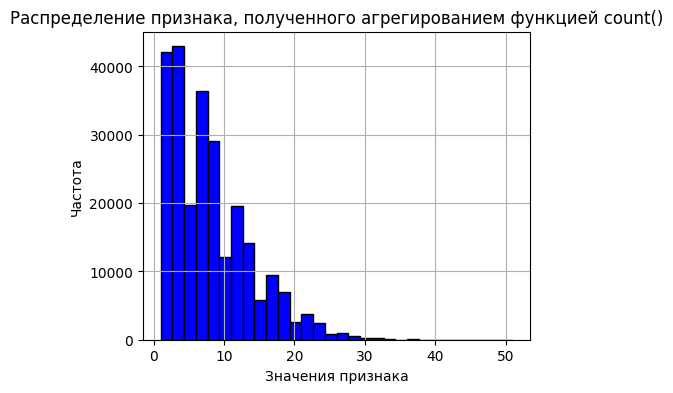

In [33]:
# Distribution of a feature obtained by aggregation with the count() function
plt.figure(figsize=(5, 4))  

# Plot the histogram with customizations
plt.hist(df['rn'], bins=30, color='blue', edgecolor='black')

plt.title('Распределение признака, полученного агрегированием функцией count()')
plt.xlabel('Значения признака')
plt.ylabel('Частота')

plt.grid(True)  # Add grid
plt.show()


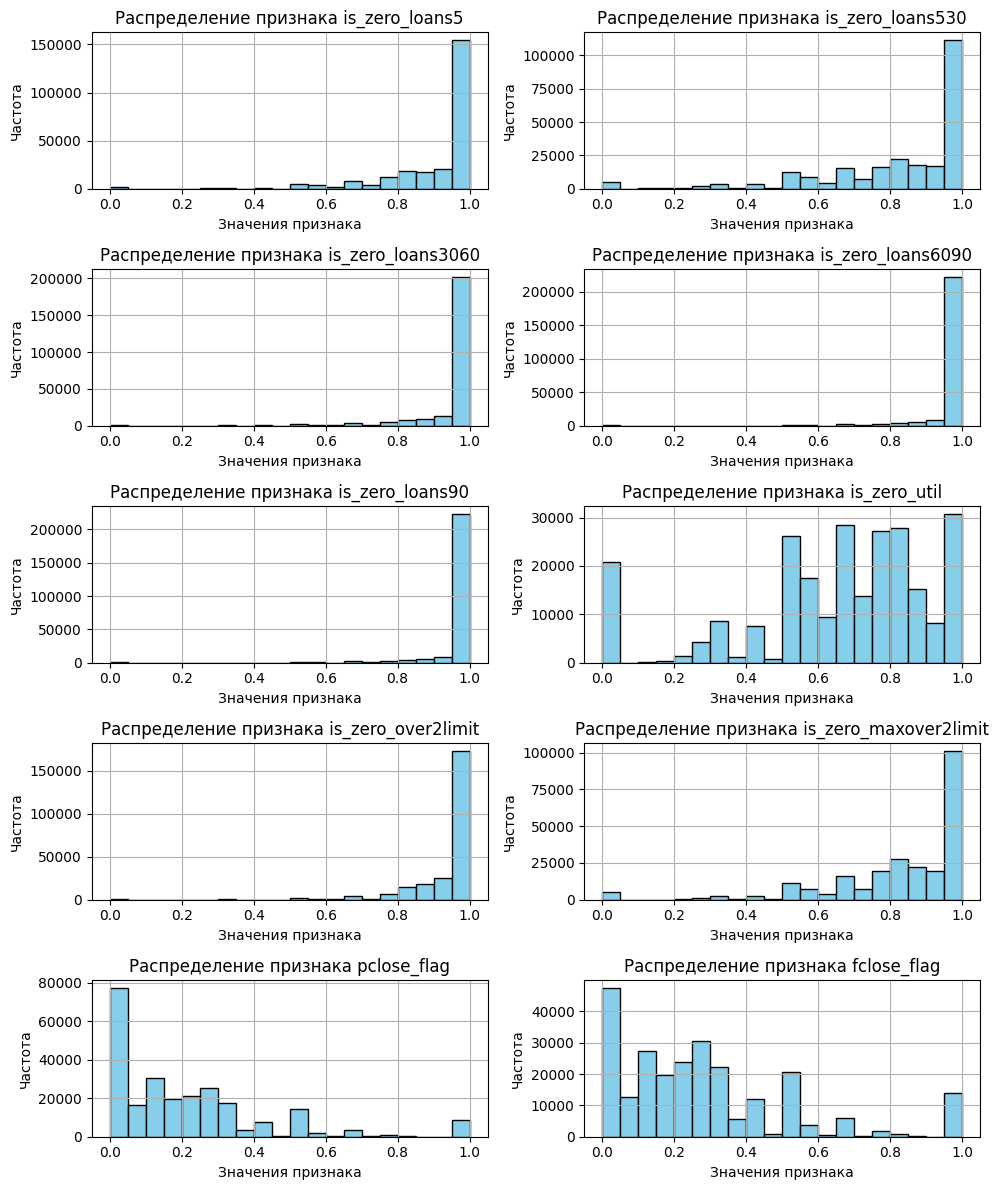

In [34]:
# Distribution of features obtained by aggregation with the mean() function
fig, axes = plt.subplots(nrows=len(flag_cols)//2 + len(flag_cols)%2, ncols=2, figsize=(10, 12))
axes = axes.flatten()

# Plot each histogram on its own subplot
for i, col in enumerate(flag_cols):
    axes[i].hist(df[col], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Распределение признака {col}')
    axes[i].set_xlabel('Значения признака')
    axes[i].set_ylabel('Частота')
    axes[i].grid(True)  # Add grid

# Remove empty subplots if flag_cols is odd
if len(flag_cols) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


In [35]:
# drop column 'id' as it is not a feature
df = df.drop(['id'], axis=1)
df

,rn,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,pclose_flag,...,enc_loans_credit_type_0,enc_loans_credit_type_1,enc_loans_credit_type_2,enc_loans_credit_type_3,enc_loans_credit_type_4,enc_loans_credit_type_5,enc_loans_account_cur_0,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_infrequent_sklearn
0,10,0.900000,1.000000,1.000000,1.000000,1.000000,0.600000,0.900000,0.900000,0.100000,...,0,1,0,2,7,0,0,10,0,0
1,14,0.857143,0.714286,0.857143,0.857143,0.785714,0.714286,0.857143,0.785714,0.071429,...,0,3,0,3,8,0,0,14,0,0
2,3,1.000000,0.666667,0.666667,0.666667,1.000000,0.333333,1.000000,0.666667,0.666667,...,0,0,0,2,1,0,0,3,0,0
3,15,1.000000,1.000000,1.000000,1.000000,1.000000,0.533333,0.933333,0.933333,0.333333,...,0,1,0,4,9,1,0,15,0,0
4,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,13,1.000000,0.923077,1.000000,1.000000,1.000000,0.692308,1.000000,0.923077,0.076923,...,0,1,0,2,7,3,0,13,0,0
249996,23,0.826087,0.826087,1.000000,1.000000,1.000000,0.782609,0.869565,0.739130,0.217391,...,0,4,0,7,9,3,0,23,0,0
249997,7,1.000000,0.714286,1.000000,1.000000,1.000000,1.000000,1.000000,0.857143,0.142857,...,1,0,2,2,2,0,0,6,1,0
249998,5,1.000000,0.800000,1.000000,0.800000,0.600000,0.200000,0.600000,0.600000,0.400000,...,0,1,0,2,2,0,0,5,0,0


In [36]:
target = pd.read_csv('data/train_target.csv')[0:250000].astype({'id':'int32', 'flag':'int8'})
print(target.shape)
target.head()

(250000, 2)


,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [37]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   id      250000 non-null  int32
 1   flag    250000 non-null  int8 
dtypes: int32(1), int8(1)
memory usage: 1.2 MB


In [38]:
# Target variable.
y = target['flag']

In [39]:
# Check the balance
y.value_counts(normalize=True)

flag
0    0.969064
1    0.030936
Name: proportion, dtype: float64

to determine the strategy, we experiment with various methods



In [40]:
models = [
    LogisticRegression(random_state=1),
    RandomForestClassifier(random_state=1),
    CatBoostClassifier(random_seed=1, verbose=0),  # Adding verbose=0 to suppress output
    KNeighborsClassifier(), 
    MLPClassifier(random_state=1),
    SVC(random_state=1)
]

In [41]:
for model in models:
    # Perform cross-validation
    cv_results = cross_validate(model, df, y, scoring='roc_auc', cv=4, n_jobs=-1)
    
    print(f'Model: {model.__class__.__name__}')
    print(f'Training Time: {cv_results["fit_time"]}')
    print(f'ROC-AUC Score: {cv_results["test_score"].mean().round(4)} ± {cv_results["test_score"].std().round(4)}')
    print()


Model: LogisticRegression
Training Time: [17.01577234 15.42716455 16.74479675 16.59375978]
ROC-AUC Score: 0.7478 ± 0.0025

Model: RandomForestClassifier
Training Time: [239.78461766 240.53276515 238.8079052  237.06231308]
ROC-AUC Score: 0.7077 ± 0.0038

Model: CatBoostClassifier
Training Time: [474.36652708 473.26677561 474.40721345 473.62616205]
ROC-AUC Score: 0.7661 ± 0.0016

Model: KNeighborsClassifier
Training Time: [1.98090625 2.24129176 2.21379876 1.92063069]
ROC-AUC Score: 0.5617 ± 0.002



I interrupted the kernel after 8 hours of running and not showing the result of MLPClassifier


The KNeighborsClassifier model exhibits a low metric. Meanwhile, the SVC and MLPClassifier models have extremely long training times (no results were obtained even after almost 8 hours). Therefore, we will not use these models.

We will continue to work with the remaining three models. 

Let’s create a feature that represents the sum of points (or “weights of gravity”). Let's add up the characteristics obtained by aggregating by the average value, but using multiplier coefficients (1-1.5-2-2.5-3). The highest value of the coefficient applies to the “proportion of absence of overdue payments for more than 90 days,” since such overdue payments are the most critical. Accordingly, the smallest coefficient applies to the “proportion of absence of delays of less than 5 days,” as less critical. We get: the higher the score, the more trust the client deserves.

In [42]:
df['is_zero_loans_points'] = df['is_zero_loans5']*1 + df['is_zero_loans530']*1.5 + df['is_zero_loans3060']*2 + df['is_zero_loans6090']*2.5 + df['is_zero_loans90']*3
df['is_zero_loans_points']

0          9.900000
1          8.142857
2          8.000000
3         10.000000
4         10.000000
            ...    
249995     9.884615
249996     9.565217
249997     9.571429
249998     8.000000
249999    10.000000
Name: is_zero_loans_points, Length: 250000, dtype: float64

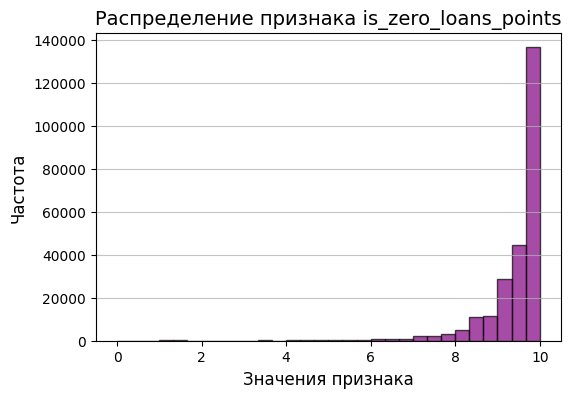

In [43]:
#Distribution of new feature
plt.figure(figsize=(6, 4))  

plt.hist(df['is_zero_loans_points'], bins=30, color='purple', edgecolor='black', alpha=0.7)
plt.title('Распределение признака is_zero_loans_points', fontsize=14)
plt.xlabel('Значения признака', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()


Let's create a feature that sums up the number of time intervals where the share of missing delays is less than 0.6. The more such time intervals, the less trust the client deserves.

In [44]:
is_zero_cols = ['is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90']

df['is_zero_loans_risk'] = df[is_zero_cols].lt(0.6).sum(axis=1)
df['is_zero_loans_risk'].value_counts()

is_zero_loans_risk
0    206608
1     36289
2      3974
3      1487
4      1453
5       189
Name: count, dtype: int64

In [45]:
# Посмотрим на метрики на датафрейме с двумя новыми признаками .
models = [
    LogisticRegression(random_state=1),
    RandomForestClassifier(random_state=1),
    CatBoostClassifier(random_seed=1, verbose=0) 
]


In [46]:
for model in models:
    # Perform cross-validation
    cv_results = cross_validate(model, df, y, scoring='roc_auc', cv=3, n_jobs=-1)
    
    # Print the results for the current model
    print(f'Model: {model.__class__.__name__}')
    print(f'Training Time: {cv_results["fit_time"]}')
    print(f'ROC-AUC: {cv_results["test_score"].mean().round(4)} ± {cv_results["test_score"].std().round(4)}')
    print()


Модель:  LogisticRegression(random_state=12)
Время обучения [7.12038016 7.41725612 7.29225826]
Roc-auc: 0.7485 Дисперсия: 0.0066

Модель:  RandomForestClassifier(random_state=12)
Время обучения [57.75568199 58.64775896 57.19174933]
Roc-auc: 0.7081 Дисперсия: 0.0075

Модель:  <catboost.core.CatBoostClassifier object at 0x000001EF69FD6250>
Время обучения [57.00701261 56.66295671 57.00822949]
Roc-auc: 0.7636 Дисперсия: 0.0045



In [47]:
# It can be seen that after adding new prizes the metric has increased. 
# We will further take this fact into account